# Isochrone Map exploration

[Isochrone](https://en.wikipedia.org/wiki/Isochrone_map) is a type of map that tell "given a 30 minutes travel distance from point of origin, how far can I go away?". It is useful for understanding accessibility of a location.

In this writing, I am exploring how to create an isochrone map with OSM data.

The Python is a well known language for geospatial analysis, and there are many libraries available. Here I am using [osmnx](https://osmnx.readthedocs.io/en/stable/) to download from OpenStreetMap, and it will also automatically convert it to and [networkx](https://networkx.org/documentation/stable/) graph so we can do fancy graph related observation. Who would have know that all those DFS and BFS leetcode problem is actually useful for something.

This is also a fun exercise to learn using AI assisted coding with [Cursor](https://www.cursor.com/). I have zero experience working with OSM or network graph before. By the helps of prompting, as long as I know **what** I want, the **how** can be figured out by the AI. There was some place where the AI don't get it right the first time. Usually I can just copy paste the error message and the AI will fix it with a new suggestion. On some rare occasion where it still incorrect after few iteration, only then I will need to actually read and understand the code to do manual fix.

In [1]:
import networkx as nx
import osmnx as ox
from matplotlib import pyplot as plt

ox.__version__

'1.9.4'

## Configuration

In here we define the point of interest (POI), the radius of the isochrone, and the speed we can travel according to the road type.

OSM have `highway` tag to define the type of road. The exact detail of it usually differ slightly per country. For Indonesia you can see it [here](https://wiki.openstreetmap.org/wiki/Id:Indonesian_Tagging_Guidelines#Jalan). 

I took some liberty on defining the speed. For example `motorway` or toll road speed limit is 100 km/h and people usually drive faster than that when the traffic allow. But that just it, *when* traffic allow. More often than not it is congested everywhere in Jakarta. The number below is assuming a normal work day traffic and time spent in traffic lights.


In [18]:
poi = {
    "RS Siloam TB Simatupang": (106.784365,-6.292240),
    "Airport CGK": (106.679671, -6.116638),
    "Airport HLP": (106.887048,-6.263289),
    "Bundaran HI": (106.823110, -6.194950),
    "Ancol": (106.833171,-6.128887),
    "Bekasi": (106.998875,-6.236104)
}
# The X, Y coordinate order is reversed for osmnx operations
start_point = tuple(reversed(poi["RS Siloam TB Simatupang"]))
location = "" # Use either location or start_point, not both.

radius_km = 30

trip_times = [15, 30, 45, 60, 90, 120]  # in minutes
default_road_speed = 5
default_train_speed = 50

# Speed based on road type.
# Traffic jam and red light baked in as part of road speed.
highway_speeds = {
    "motorway": 50,
    "trunk": 30,
    "primary": 25,
    "secondary": 20,
    "tertiary": 10,
    "residential": 10,
    "living_street": 4,
    "service": 5,
    "unclassified": 5,
    "busway": 40,
    "footway": 3,
}

iso_colors = ox.plot.get_colors(n=len(trip_times), cmap="YlGnBu", start=0)

## Downloading the road graph

We will download the road graph from OSM. The OSMNX already provide a easy function to download part of map based on place name, point, or bounding box.

This also cache the graph to a file, so we don't need to download it next time.

A 30 km radius of all road network around Jakarta is about 400 MB, so we also cache it to make it easier when we iterate on the code.

C:\Users\adhik\AppData\Roaming\Python\Python312\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


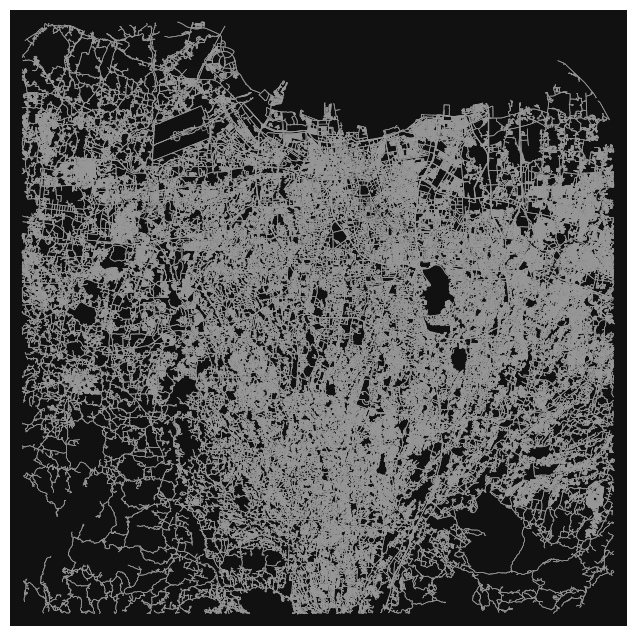

In [5]:
import os

if location:
    cache_file = f"{location}_drive.graphml"
else:
    cache_file = f"{'_'.join(map(lambda x: str(x).replace('.', '_'), start_point))}_{radius_km}_drive.graphml"

# Check if the cache file exists
if os.path.exists(cache_file):
    # Load the graph from the cache file
    G = ox.load_graphml(cache_file)
else:
    # Download the graph and save it to the cache file
    if location:
        G = ox.graph_from_place(location, network_type="drive")
    else:
        G = ox.graph_from_point(center_point=start_point, dist=radius_km*1000, network_type="drive")
    ox.save_graphml(G, cache_file)

G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, edge_color='#999999', edge_linewidth=0.5, node_size=0)

## The railway graph

Railway is a bit different than road. It is a separate network, and we need to add it manually.

We will also add a new attribute to each edge to indicate it is a railway. So postprocessing later will be easier.

The `retain_all` argument is important. By default OSMNX will simplify the graph by removing nodes that are not part of the main network. The train network in Jakarta is consisted of several disjointed lines (MRT, LRT, and KRL), and we want to retain all nodes and edges to represent that.


C:\Users\adhik\AppData\Roaming\Python\Python312\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(


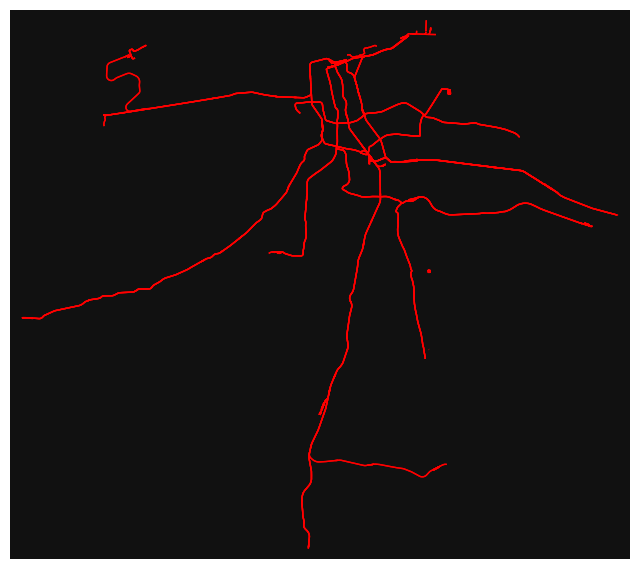

In [19]:
railway_G = ox.graph_from_point(center_point=start_point, dist=radius_km*1000, custom_filter='["railway"]', retain_all=True)
railway_G = ox.project_graph(railway_G)
# Add 'railway' attribute to each edge in railway_G
for u, v, k, data in railway_G.edges(keys=True, data=True):
    railway_G[u][v][k]['railway'] = 'train'

fig, ax = ox.plot_graph(railway_G, edge_color='#FF0000', edge_linewidth=1, node_size=0)

## The railway station

OSMNX is great for road network. But railway station is an OSM feature or node that is not part of railway network.

So we download it separately using Overpass API. We use the filter `railway=station` to ensure we only get relevant nodes.

On hindsight after I understand more about the library and OSM data structure, I can also use [osmnx feature function](https://osmnx.readthedocs.io/en/stable/user-reference.html#module-osmnx.features) to get the same data.

In [20]:
import requests
from shapely.geometry import Point
import geopandas as gpd

def get_railway_stations(center_point, radius_km):
    # Convert radius to meters
    radius_m = radius_km * 1000
    
    # Overpass API query
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    (
      node["railway"="station"](around:{radius_m},{center_point[0]},{center_point[1]});
    );
    out center;
    """
    
    # Send request to Overpass API
    response = requests.get(overpass_url, params={'data': overpass_query})
    data = response.json()
    
    # Extract station information
    stations = []
    for element in data['elements']:
        if element['type'] == 'node':
            lat, lon = element['lat'], element['lon']
        else:  # way or relation
            lat, lon = element['center']['lat'], element['center']['lon']
        
        name = element['tags'].get('name', 'Unnamed Station')
        stations.append({
            'name': name,
            'geometry': Point(lon, lat)
        })
    
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(stations, crs="EPSG:4326")
    
    return gdf

# Get railway stations
railway_stations = get_railway_stations(start_point, radius_km)
print(f"Found {len(railway_stations)} railway stations.")


Found 130 railway stations.


### Add railway station to the railway graph

Since the railway station is not part of the railway graph, we need to add it manually.

I was having trouble with adding the railway station to the railway graph, because the railway graph is a multi point LineString, that means a single edge is not just a line between A to B but can curve and turn around. When we want to add the station node, we need to split the edge to two, and add the node in the middle.

In [8]:
from shapely.geometry import LineString, Point

# Project railway stations to the same CRS as G
railway_stations = railway_stations.to_crs(railway_G.graph['crs'])

# Function to add a node to the graph, splitting an edge if necessary
def add_node_to_graph(G, point, node_id):
    nearest_edge = ox.nearest_edges(G, X=[point.x], Y=[point.y])[0]
    u, v, key = nearest_edge
    
    # Get the geometry of the nearest edge
    edge_data = G.edges[u, v, key]
    if 'geometry' not in edge_data:
        # If there's no geometry, create a straight line between the nodes
        start_point = Point(G.nodes[u]['x'], G.nodes[u]['y'])
        end_point = Point(G.nodes[v]['x'], G.nodes[v]['y'])
        edge_geom = LineString([start_point, end_point])
    else:
        edge_geom = edge_data['geometry']
    
    # Find the nearest point on the edge geometry
    split_point = edge_geom.interpolate(edge_geom.project(point))
    
    # Get all coordinates of the original edge
    coords = list(edge_geom.coords)
    
    # Find the index where to insert the split point
    insert_index = next(i for i, coord in enumerate(coords) if LineString(coords[i:i+2]).distance(split_point) < 1e-8)
    
    # Create two new geometries, preserving all original points
    line1_coords = coords[:insert_index] + [split_point.coords[0]]
    line2_coords = [split_point.coords[0]] + coords[insert_index:]
    
    # Check if the coordinates are valid before creating LineStrings
    if len(line1_coords) > 1:
        line1 = LineString(line1_coords)
    else:
        line1 = None
    
    if len(line2_coords) > 1:
        line2 = LineString(line2_coords)
    else:
        line2 = None
    
    # Add the new node
    G.add_node(node_id, x=point.x, y=point.y, role="station")
    
    # Add new edges
    new_edge_data = edge_data.copy()
    if line1:
        new_edge_data['geometry'] = line1
        G.add_edge(u, node_id, **new_edge_data)
    if line2:
        new_edge_data['geometry'] = line2
        G.add_edge(node_id, v, **new_edge_data)
    
    # Remove the original edge
    G.remove_edge(u, v, key)

# Add railway stations to the graph
for idx, row in railway_stations.iterrows():
    node_id = f"station_{idx}"
    add_node_to_graph(railway_G, row.geometry, node_id)

print(f"Added {len(railway_stations)} railway stations to the graph.")

Added 130 railway stations to the graph.


To verify above code is right, let's plot the railway graph with stations highlighted.

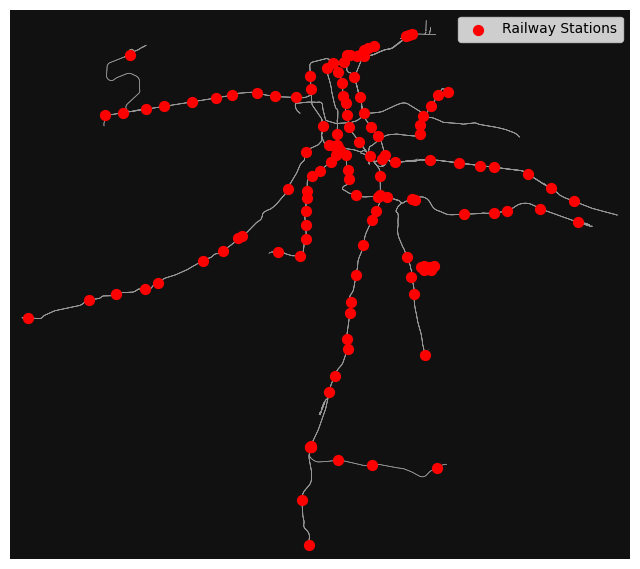

In [9]:
# Plot the railway graph with stations highlighted
fig, ax = ox.plot_graph(railway_G, node_size=0, edge_color='#999999', edge_linewidth=0.5, show=False, close=False)

# Plot station nodes as big red markers
station_nodes = [node for node, data in railway_G.nodes(data=True) if data.get('role') == 'station']
station_coords = [(railway_G.nodes[node]['x'], railway_G.nodes[node]['y']) for node in station_nodes]
x, y = zip(*station_coords)
ax.scatter(x, y, c='red', s=50, zorder=3, label='Railway Stations')
plt.legend()
plt.show()


### Connecting road and railway

In OSM road and railway is a separate network. But I am interested in the accessibility by combining mean of travel by car/bike and with train. So I need to connect the road network to the nearest railway station.

This use osmnx `nearest_nodes`. Initially the AI is using naive brute force approach that iterate over all nodes, which are about 4x slower than osmnx version.

In [11]:
from tqdm import tqdm

road_and_rail_G = G

connected_count = 0
railway_station_nodes = [(n, data) for n, data in railway_G.nodes(data=True) if data.get('role') == 'station']
for station_node, data in tqdm(railway_station_nodes, desc="Processing train stations", unit="station"):
    nearest_road_node, distance = ox.distance.nearest_nodes(
        road_and_rail_G, 
        X=data['x'], 
        Y=data['y'], 
        return_dist=True)
    if nearest_road_node:
        road_and_rail_G.add_node(station_node, **data)
        road_and_rail_G.add_edge(
            station_node, nearest_road_node, 
            length=distance, 
            highway='footway', 
            railway='connection',
            oneway='yes',
            geometry=LineString([
                Point(road_and_rail_G.nodes[station_node]['x'], road_and_rail_G.nodes[station_node]['y']), 
                Point(road_and_rail_G.nodes[nearest_road_node]['x'], road_and_rail_G.nodes[nearest_road_node]['y'])
            ])
        )
        road_and_rail_G.add_edge(
            nearest_road_node, station_node,
            length=distance,
            highway='footway',
            railway='connection',
            oneway='yes',
            geometry=LineString([
                Point(road_and_rail_G.nodes[nearest_road_node]['x'], road_and_rail_G.nodes[nearest_road_node]['y']),
                Point(road_and_rail_G.nodes[station_node]['x'], road_and_rail_G.nodes[station_node]['y'])
            ])
        )
        connected_count += 1

existing_nodes = set(road_and_rail_G.nodes())
existing_edges = set(road_and_rail_G.edges())

# Combine road and railway networks using networkx compose
road_and_rail_G = nx.compose(road_and_rail_G, railway_G)

# Count the number of nodes and edges added from the railway network
nodes_added = len(set(railway_G.nodes()) - existing_nodes)
edges_added = len(set(railway_G.edges()) - existing_edges)

print(f"Added {nodes_added} nodes and {edges_added} edges from the railway network.")
print(f"Connecting train station to road: {connected_count}")

Processing train stations: 100%|██████████| 130/130 [05:57<00:00,  2.75s/station]


Added 1348 nodes and 3197 edges from the railway network.
Connecting train station to road: 130


### Add travel time to each edge

Now we add the travel time to each edge.

In [12]:
def kmh_to_mpm(kmh):
    return kmh * 1000 / 60

railway_count = 0
highway_count = 0
else_count = 0
# add an edge attribute for time in minutes required to traverse each edge
for _, _, _, data in road_and_rail_G.edges(data=True, keys=True):
    if "highway" in data:
        highway_type = data.get("highway", "")
        if isinstance(highway_type, list):
            highway_type = highway_type[0] if highway_type else ""
        speed = highway_speeds.get(highway_type, default_road_speed)
        highway_count += 1
    elif "railway" in data:
        railway_count += 1
        speed = default_train_speed
    else:
        speed = default_road_speed
        else_count += 1
    
    meters_per_minute = kmh_to_mpm(speed)
    data["time"] = data["length"] / meters_per_minute

print(f"Counted travel time for: Highway: {highway_count}, Railway: {railway_count}, Else: {else_count}")

Counted travel time for: Highway: 1003966, Railway: 3241, Else: 0


## Calculate isochrone

Finally, we calculate the actual isochrone. The heavy lifting is done by `nx.ego_graph`, which calculate the subgraph of nodes within a certain distance.

Time taken for 120 minutes: 17.27 seconds
Time taken for 90 minutes: 18.74 seconds
Time taken for 60 minutes: 7.00 seconds
Time taken for 45 minutes: 3.65 seconds
Time taken for 30 minutes: 1.19 seconds
Time taken for 15 minutes: 0.13 seconds


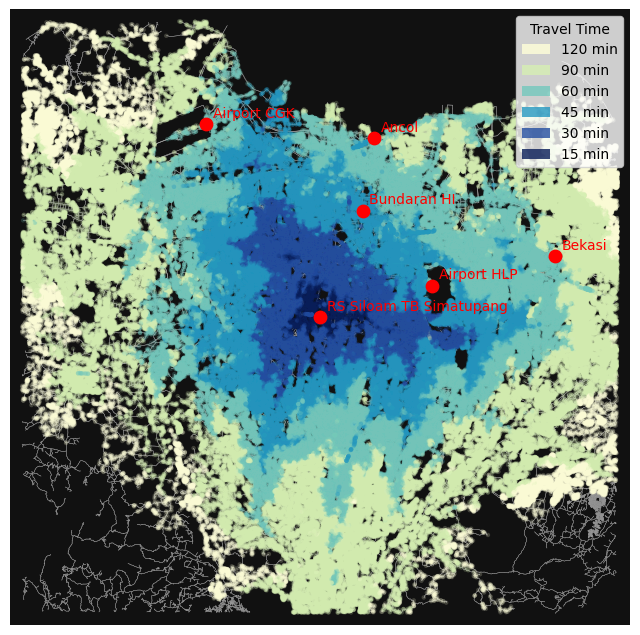

In [33]:
from matplotlib import pyplot as plt
from shapely.geometry import Point
import time

# Get the center node using global coordinates
projected_coords = ox.projection.project_geometry(Point(reversed(start_point)), to_crs=road_and_rail_G.graph['crs'])[0]
center_node = ox.distance.nearest_nodes(G, X=projected_coords.x, Y=projected_coords.y)
center_coords = G.nodes[center_node]['x'], G.nodes[center_node]['y']

node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    start_time = time.time()
    subgraph = nx.ego_graph(road_and_rail_G, center_node, radius=trip_time, distance="time")
    for node in subgraph.nodes():
        node_colors[node] = color
    end_time = time.time()
    print(f"Time taken for {trip_time} minutes: {end_time - start_time:.2f} seconds")

nc = [node_colors[node] if node in node_colors else "none" for node in road_and_rail_G.nodes()]
ns = [10 if node in node_colors else 0 for node in road_and_rail_G.nodes()]

fig: plt.Figure
ax: plt.Axes
fig, ax = ox.plot_graph(
    road_and_rail_G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.2,
    edge_linewidth=0.3,
    edge_color="#999999",
    show=False,
)

# Add markers for each POI
for name, (lon, lat) in poi.items():
    projected_lon = ox.projection.project_geometry(Point(lon, lat), to_crs=road_and_rail_G.graph['crs'])[0].coords[0][0]
    projected_lat = ox.projection.project_geometry(Point(lon, lat), to_crs=road_and_rail_G.graph['crs'])[0].coords[0][1]
    ax.scatter(projected_lon, projected_lat, c='r', s=80, zorder=5, label=name)
    ax.annotate(name, (projected_lon, projected_lat), xytext=(5, 5), textcoords='offset points', color='red')

# add labels for each travel time
legend_elements = [plt.Rectangle((0, 0), 1, 1, fc=color, ec="none", alpha=0.8) 
                   for color in iso_colors]
legend_labels = [f"{time} min" for time in sorted(trip_times, reverse=True)]
ax.legend(legend_elements, legend_labels, loc="upper right", title="Travel Time")

plt.show()

## Observation

The impact of major toll road and railway is distinguishly visible on how it make reaching some far away location easier.

## Future exploration idea

- Are there any open data source for traffic congestion and real-world road speed?
- Computation speed. It took ~30 seconds to calculate all the isochrone. But online service like [commutetimemap](https://commutetimemap.com/map) can do it in almost realtime.
- Location scoring. What are potential residental area that are close to amenities and have good travel access? Something like [walkscore](https://www.walkscore.com/)
